In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

# 1. Load Dataset

In [2]:
df = pd.read_csv('./data/total.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
df['target'] = df['oversea_inflow'].diff()

In [15]:
df['target'][0] = 0

# Data Exploration

In [16]:
df.isnull().sum()

oversea_inflow    0
roam              0
g_confirmed       0
g_deaths          0
g_recovered       0
g_dayconfirmed    0
g_daydeaths       0
g_dayrecovered    0
k_confirmed       0
k_deaths          0
k_recoverd        0
k_dayconfirmed    0
k_day_osi_1       0
target            0
dtype: int64

In [8]:
df.shape

(59, 13)

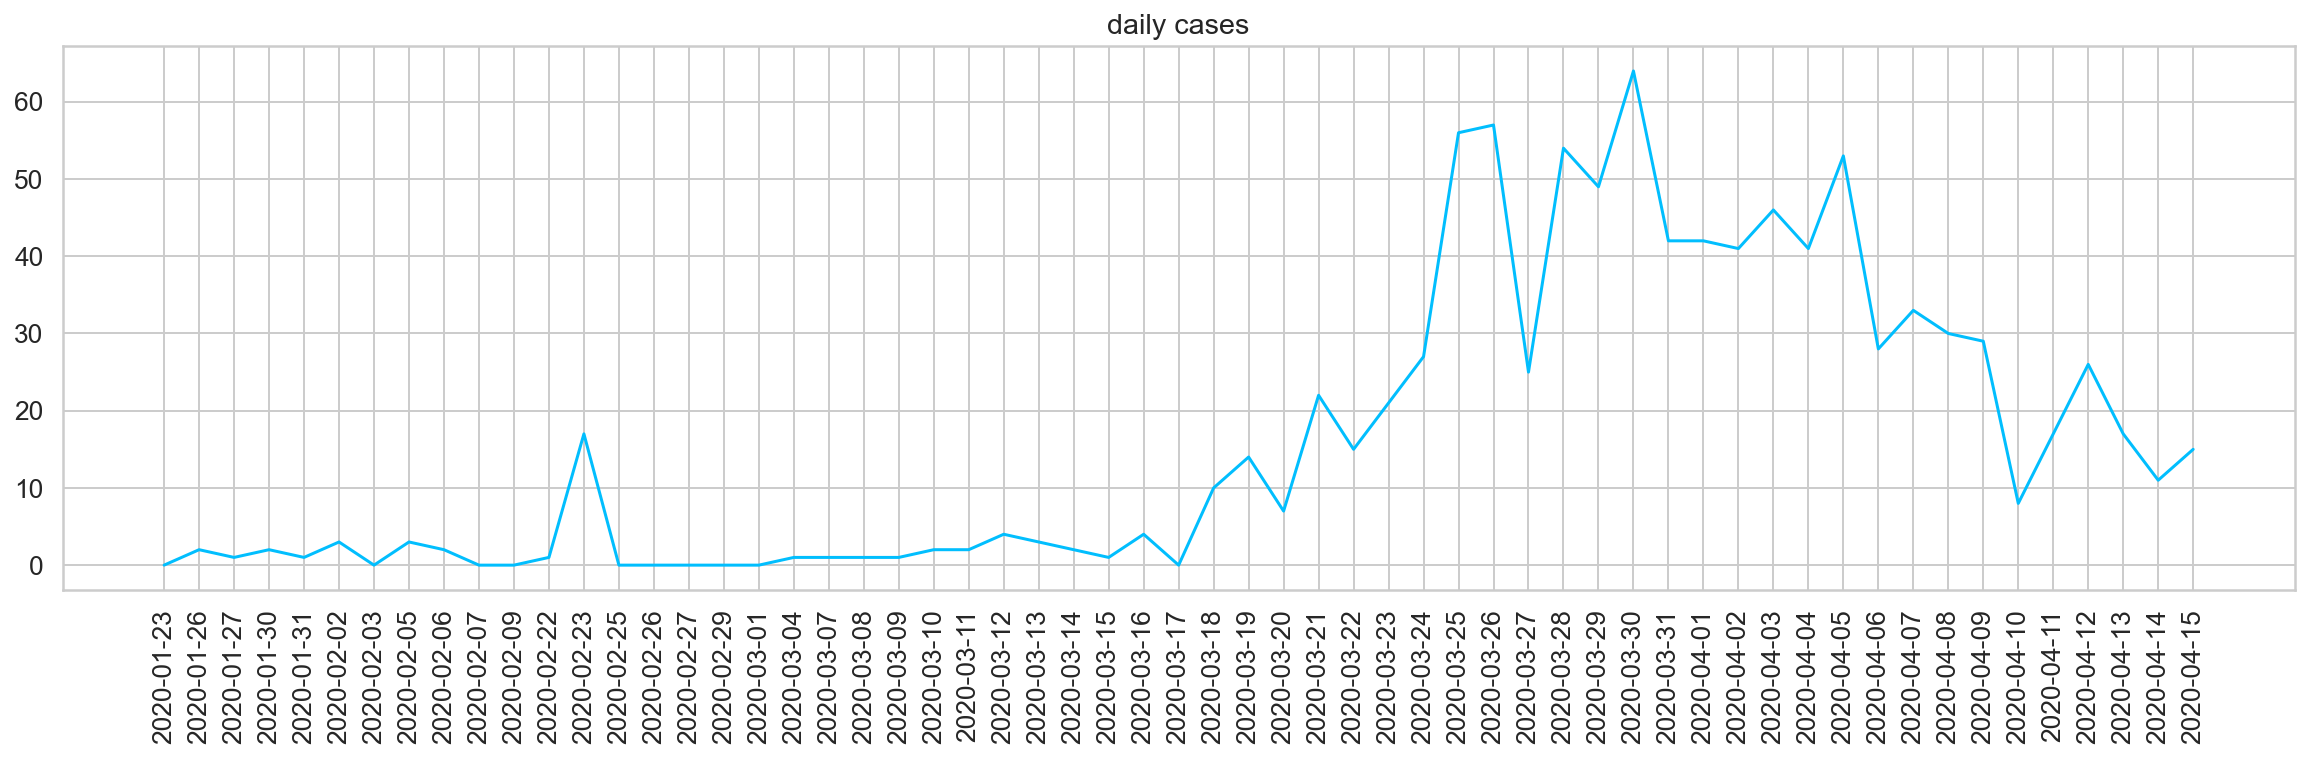

In [18]:
plt.figure(figsize=(20,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("daily cases");

In [19]:
df['target'].shape

(59,)

# Preprocessing

In [27]:
df.iloc[:,-1]

Date
2020-01-23     0.0
2020-01-26     2.0
2020-01-27     1.0
2020-01-30     2.0
2020-01-31     1.0
2020-02-02     3.0
2020-02-03     0.0
2020-02-05     3.0
2020-02-06     2.0
2020-02-07     0.0
2020-02-09     0.0
2020-02-22     1.0
2020-02-23    17.0
2020-02-25     0.0
2020-02-26     0.0
2020-02-27     0.0
2020-02-29     0.0
2020-03-01     0.0
2020-03-04     1.0
2020-03-07     1.0
2020-03-08     1.0
2020-03-09     1.0
2020-03-10     2.0
2020-03-11     2.0
2020-03-12     4.0
2020-03-13     3.0
2020-03-14     2.0
2020-03-15     1.0
2020-03-16     4.0
2020-03-17     0.0
2020-03-18    10.0
2020-03-19    14.0
2020-03-20     7.0
2020-03-21    22.0
2020-03-22    15.0
2020-03-23    21.0
2020-03-24    27.0
2020-03-25    56.0
2020-03-26    57.0
2020-03-27    25.0
2020-03-28    54.0
2020-03-29    49.0
2020-03-30    64.0
2020-03-31    42.0
2020-04-01    42.0
2020-04-02    41.0
2020-04-03    46.0
2020-04-04    41.0
2020-04-05    53.0
2020-04-06    28.0
2020-04-07    33.0
2020-04-08    30.0
2020-04

In [136]:
test_data_size = 14

train_set = df[:-test_data_size]
test_set = df[-test_data_size:]

x_train = train_set.iloc[:,:-1]
y_train = train_set.iloc[:,-1]

x_test = test_set.iloc[:,:-1]
y_test = test_set.iloc[:,-1]

print("train set : ", x_train.shape)
print("test set : ", x_test.shape)

train set :  (45, 13)
test set :  (14, 13)


In [137]:
test_data_size = 14

X = df.iloc[:,:-1]
y = df['target']

In [146]:
# x_train, x_test, y_train, y_test
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [147]:
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [148]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [149]:
seq_length = 3
X_train, X_test = create_sequences(X_train, seq_length)
y_train = create_sequences(y_train, seq_length)
X_test = create_sequences(X_test, seq_length)
y_test = create_sequences(y_test, seq_length)



In [152]:
y_train

(array([[ 0.,  2.,  1.],
        [ 2.,  1.,  2.],
        [ 1.,  2.,  1.],
        [ 2.,  1.,  3.],
        [ 1.,  3.,  0.],
        [ 3.,  0.,  3.],
        [ 0.,  3.,  2.],
        [ 3.,  2.,  0.],
        [ 2.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1., 17.],
        [ 1., 17.,  0.],
        [17.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  2.],
        [ 1.,  2.,  2.],
        [ 2.,  2.,  4.],
        [ 2.,  4.,  3.],
        [ 4.,  3.,  2.],
        [ 3.,  2.,  1.],
        [ 2.,  1.,  4.],
        [ 1.,  4.,  0.],
        [ 4.,  0., 10.],
        [ 0., 10., 14.],
        [10., 14.,  7.],
        [14.,  7., 22.],
        [ 7., 22., 15.],
        [22., 15., 21.],
        [15., 21., 27.],
        [21., 27., 56.],
        [27., 56., 57.],
        [56., 57., 25.],
        [57., 25., 54.],
        [25., 54., 49.],


In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [145]:
X_train

tensor([], size=(2, 0))

In [49]:
print((X_train.shape))
print((X_test.shape))

torch.Size([41, 3, 14])
torch.Size([10, 3, 14])


In [50]:
X_train[:2]

tensor([[[0.0000e+00, 6.5799e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.5778e-03, 8.0883e-01, 1.5709e-03, 8.1212e-04, 1.1469e-04,
          7.7980e-03, 2.7654e-03, 7.1050e-04, 2.0231e-04, 0.0000e+00,
          0.0000e+00, 1.2300e-03, 0.0000e+00, 3.1250e-02],
         [5.3667e-03, 1.0000e+00, 2.4390e-03, 1.3678e-03, 1.6161e-04,
          9.4643e-03, 5.3180e-03, 4.5214e-04, 3.0346e-04, 0.0000e+00,
          0.0000e+00, 1.2300e-03, 0.0000e+00, 1.5625e-02]],

        [[3.5778e-03, 8.0883e-01, 1.5709e-03, 8.1212e-04, 1.1469e-04,
          7.7980e-03, 2.7654e-03, 7.1050e-04, 2.0231e-04, 0.0000e+00,
          0.0000e+00, 1.2300e-03, 0.0000e+00, 3.1250e-02],
         [5.3667e-03, 1.0000e+00, 2.4390e-03, 1.3678e-03, 1.6161e-04,
          9.4643e-03, 5.3180e-03, 4.5214e-04, 3.0346e-04, 0.0000e+00,
          0.0000e+00, 1.2300e-03, 0.0000e+00, 1.5625e-02],
   

In [51]:
y_train.shape

torch.Size([41, 14])

In [52]:
y_train[:2]

tensor([[8.9445e-03, 6.1525e-01, 8.1335e-03, 3.2699e-03, 5.8908e-04, 2.6247e-02,
         7.8707e-03, 9.6887e-04, 3.0346e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.1739e-02, 3.1250e-02],
        [1.0733e-02, 6.6347e-01, 9.9501e-03, 4.1675e-03, 1.0009e-03, 2.1248e-02,
         8.7215e-03, 4.9735e-03, 1.0115e-03, 0.0000e+00, 0.0000e+00, 8.6101e-03,
         0.0000e+00, 1.5625e-02]])

# Building a Model

In [96]:
class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [97]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

GeForce GTX 1050 Ti
1


In [98]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 200
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [100]:
model = CoronaVirusPredictor(n_features=14, n_hidden=128, seq_len=seq_length, n_layers=4)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 80.97743225097656 test loss: 225.8566131591797
Epoch 10 train loss: 47.81605911254883 test loss: 159.28221130371094
Epoch 20 train loss: 38.027278900146484 test loss: 71.9755859375
Epoch 30 train loss: 26.67548942565918 test loss: 66.94259643554688
Epoch 40 train loss: 25.457670211791992 test loss: 81.71917724609375
Epoch 50 train loss: 24.84980010986328 test loss: 67.89387512207031
Epoch 60 train loss: 24.83235740661621 test loss: 66.07135772705078
Epoch 70 train loss: 24.78502655029297 test loss: 67.63172149658203
Epoch 80 train loss: 24.75798225402832 test loss: 67.18370056152344
Epoch 90 train loss: 24.746004104614258 test loss: 67.3434066772461
Epoch 100 train loss: 24.73758888244629 test loss: 66.7818603515625
Epoch 110 train loss: 24.732175827026367 test loss: 66.48363494873047
Epoch 120 train loss: 24.72760009765625 test loss: 66.52069091796875
Epoch 130 train loss: 24.72382164001465 test loss: 66.44380950927734
Epoch 140 train loss: 24.720569610595703 test 

In [102]:
import torch
import torch.nn as nn
from torch.autograd import Variable

time_steps = 10
batch_size = 3
in_size = 5
classes_no = 7

model = nn.LSTM(in_size, classes_no, 2)
input_seq = Variable(torch.randn(time_steps, batch_size, in_size))
output_seq, _ = model(input_seq)
last_output = output_seq[-1]

loss = nn.CrossEntropyLoss()
target = Variable(torch.LongTensor(batch_size).random_(0, classes_no-1))
err = loss(last_output, target)
err.backward()

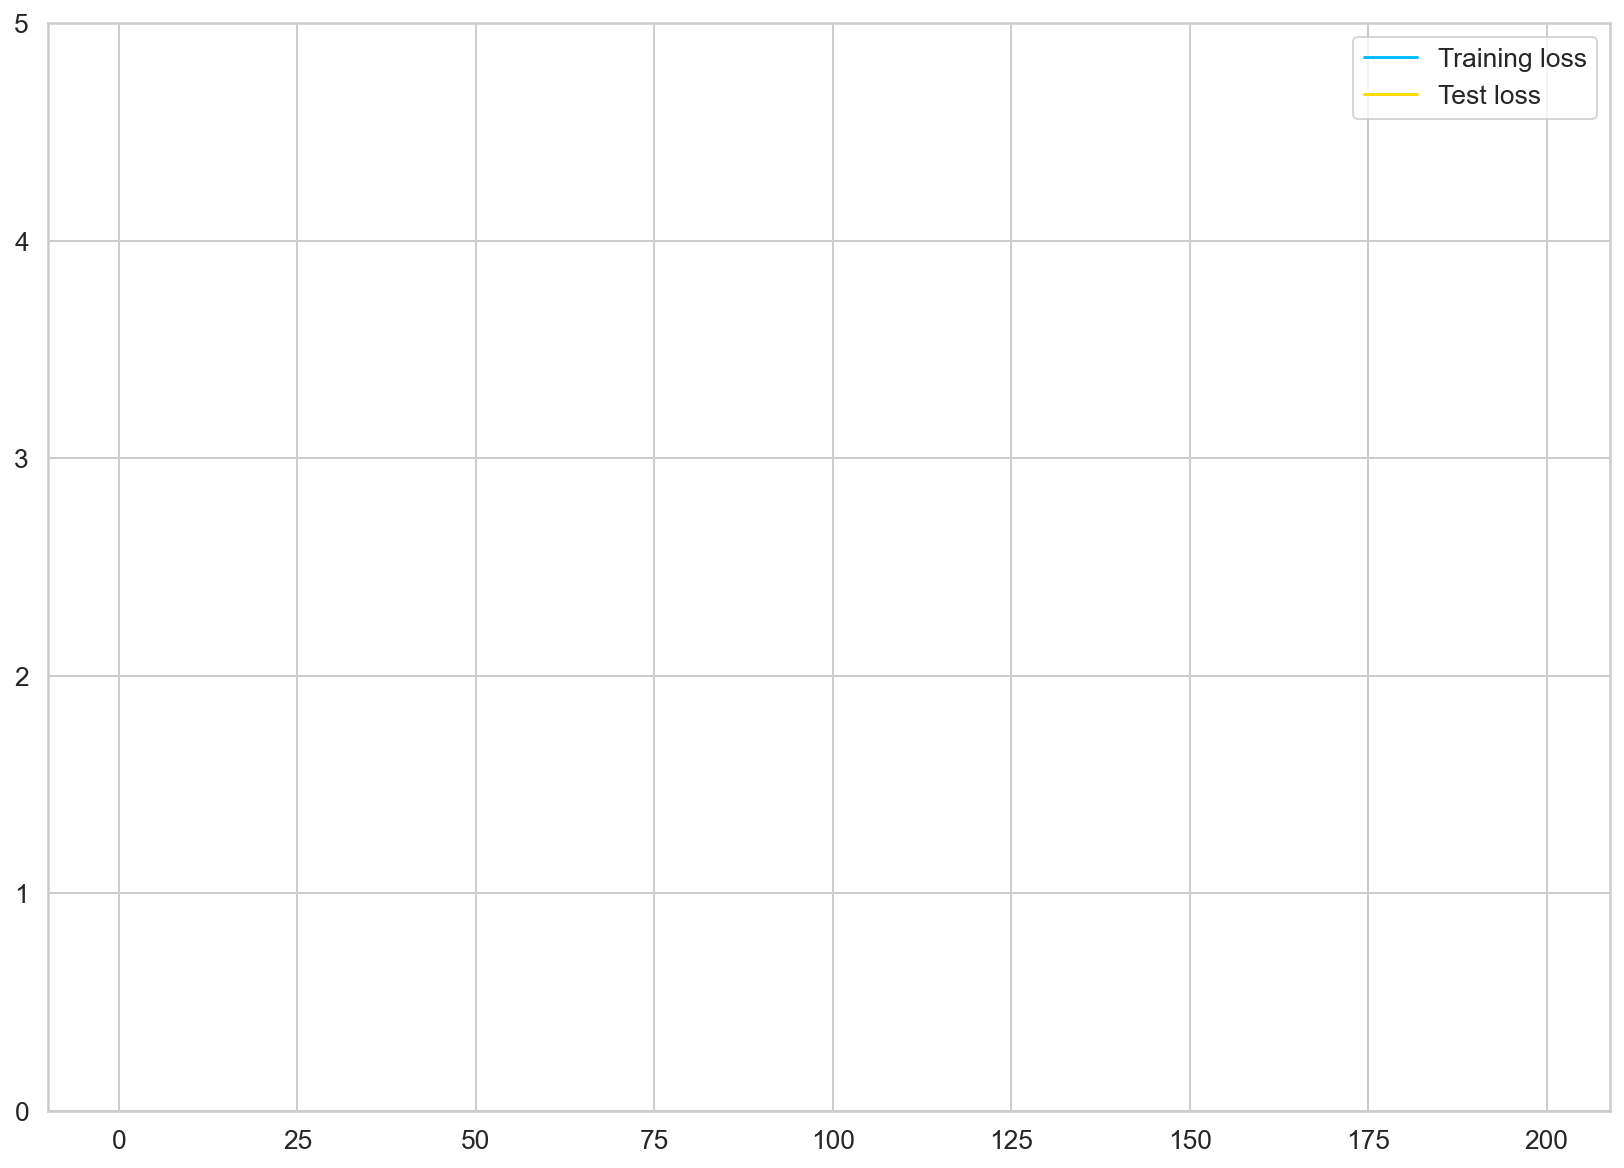

In [101]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend()

# Predicting daily cases

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

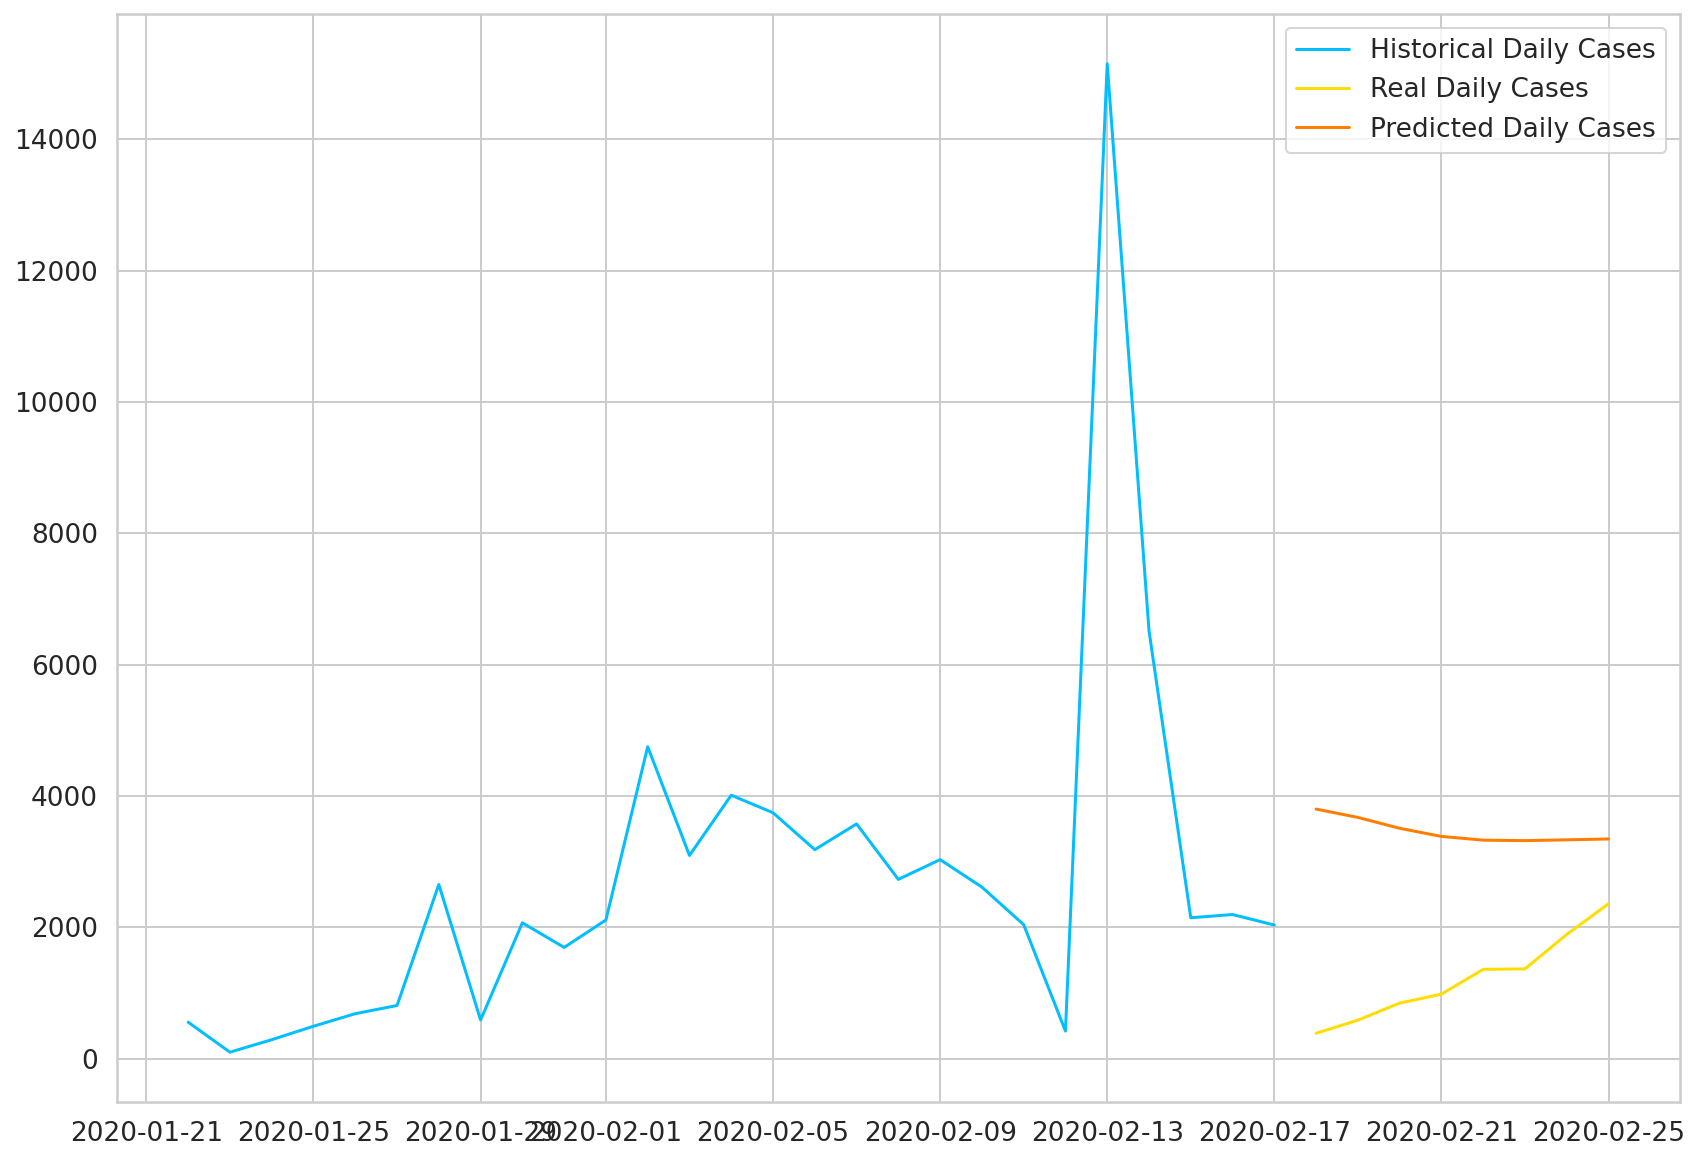

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)

plt.legend();

# Use all data for training

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(41, 1)

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.3610650300979614
Epoch 10 train loss: 0.8410776257514954
Epoch 20 train loss: 0.8266903162002563
Epoch 30 train loss: 0.8154759407043457
Epoch 40 train loss: 0.82558274269104
Epoch 50 train loss: 0.830647885799408


# Predicting future cases

In [ ]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

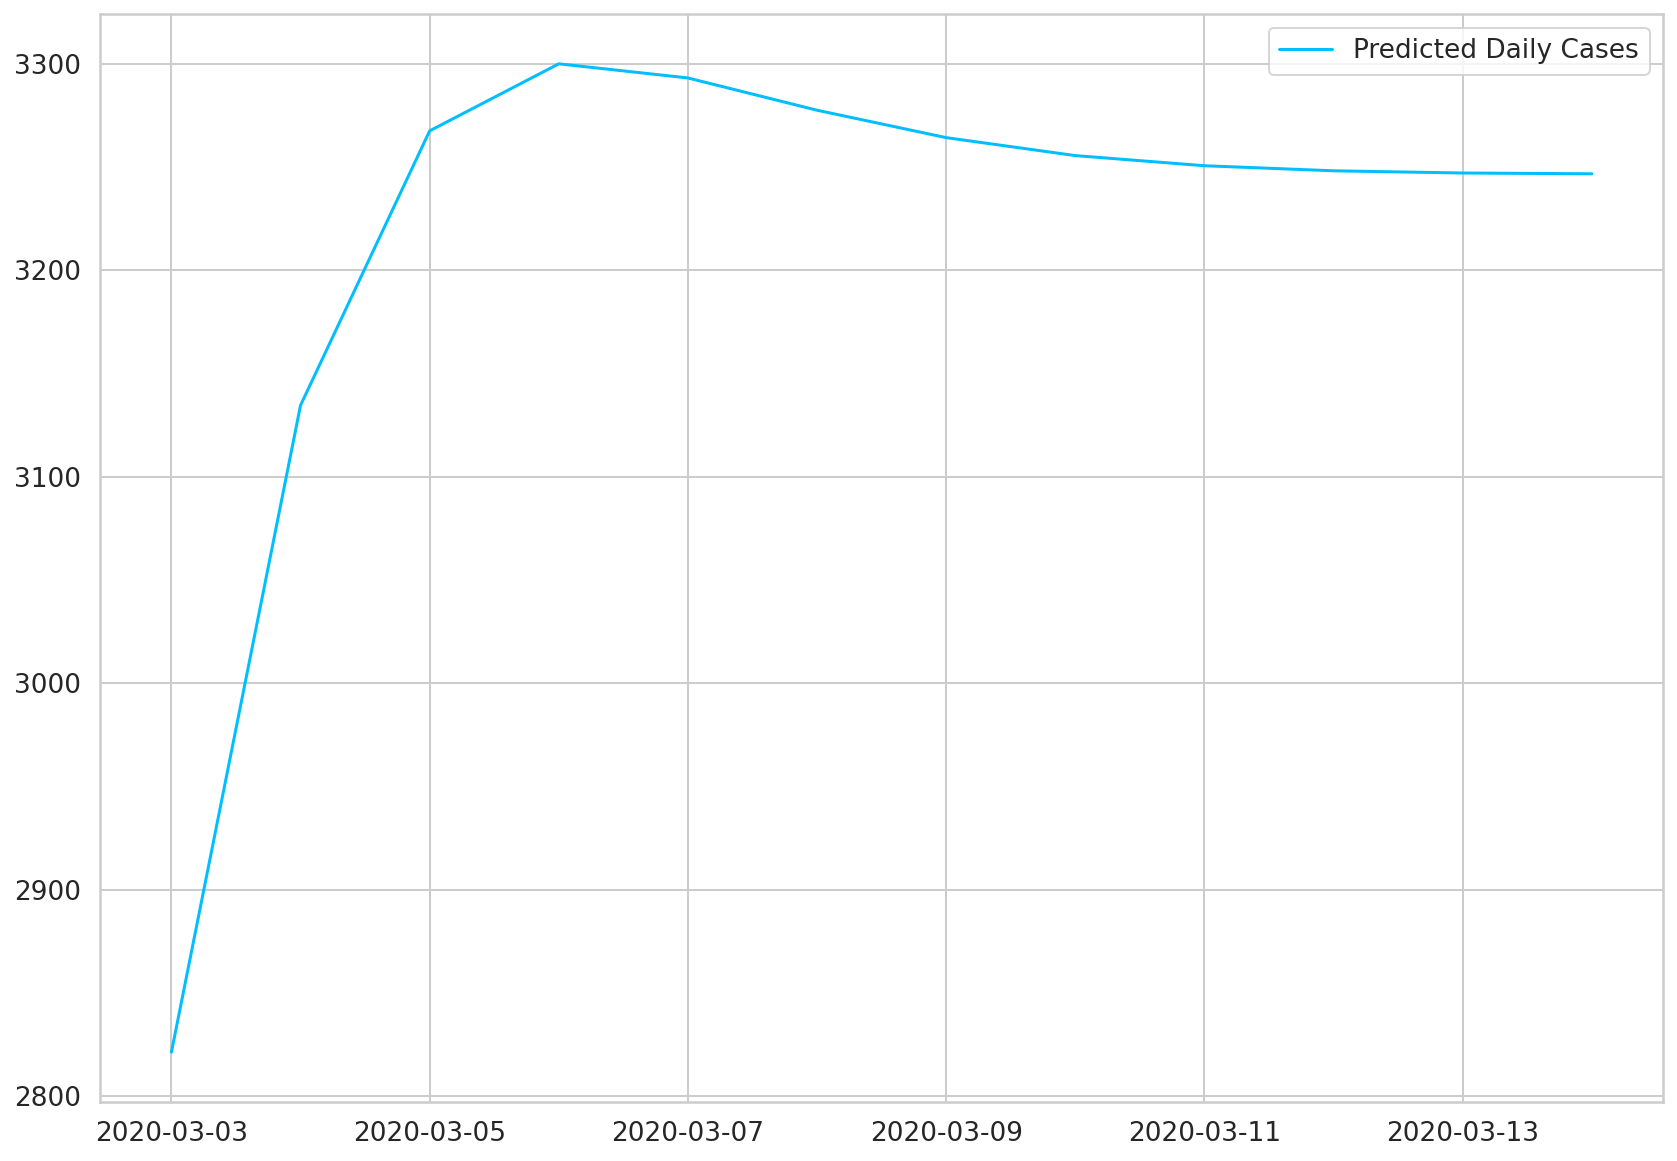

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

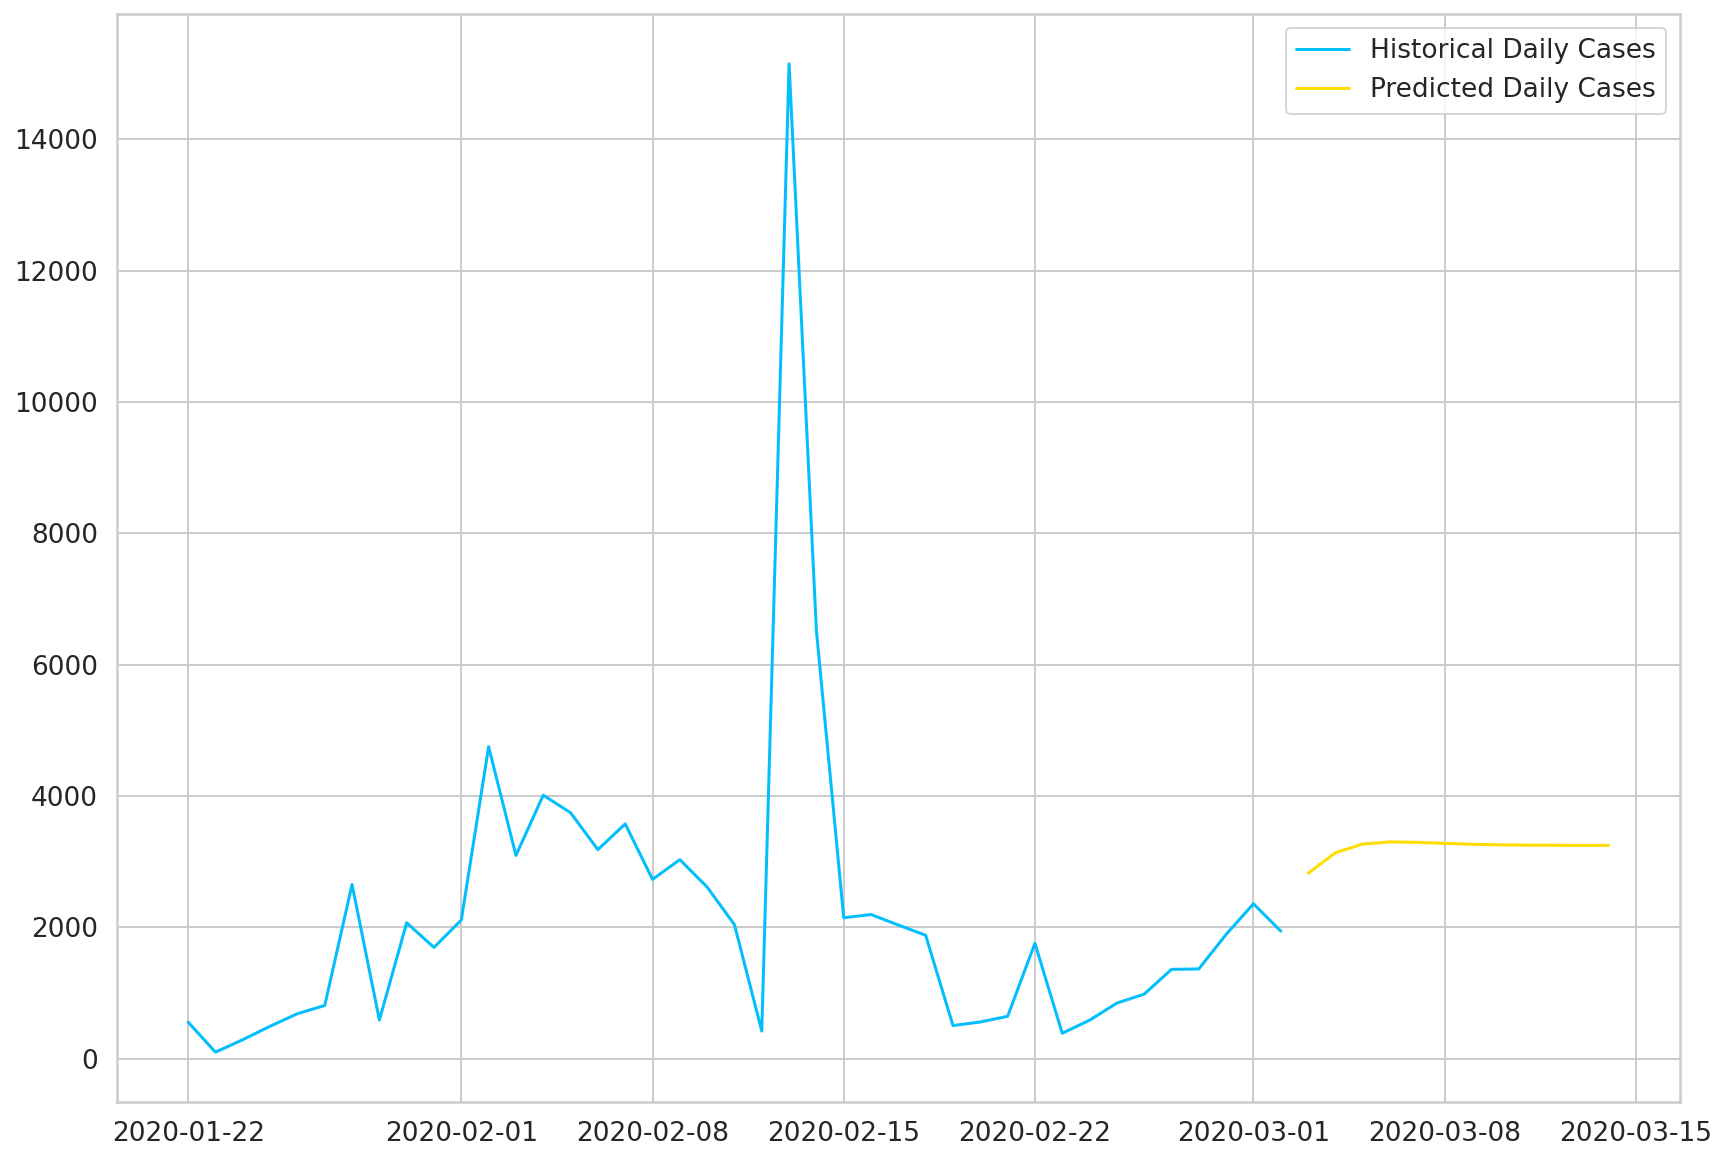

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();